In this notebook, I have tried to explore credit card fraud detection data from Kaggle and create a model to predict fraud cases.

dataset link: https://www.kaggle.com/mlg-ulb/creditcardfraud

I have tried four classifiers from sklearn: KNearest Neighbor, Random Forest Classifier, Logistic Regression, Support Vector Machine.

Then, the models have been evaluated to see which has perfromed better.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, plot_confusion_matrix

%matplotlib inline

In [2]:
# importing data

data_df = pd.read_csv(r"F:\Personal Interest\Data science\Kaggle\Credit Card Fraud Detection\Data\creditcard.csv")

print(data_df.shape)

# checking preview of imported data
data_df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# creating copy of original dataframe

df_data = data_df.copy()

In [4]:
# dropping the Time column

df_data.drop('Time', axis=1, inplace=True)

# removing any rows with NA values
df_data.dropna(inplace=True)

In [5]:
non_fraud = df_data[df_data['Class'] == 0] # filtering only non-fraud cases
fraud = df_data[df_data['Class'] == 1] # filtering fraud cases

print("Statistics of 'Amount' column in data for non-fraud class: ")
print(non_fraud['Amount'].describe())

print("Statistics of 'Amount' column in data for fraud class: ")
print(fraud['Amount'].describe())

Statistics of 'Amount' column in data for non-fraud class: 
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
Statistics of 'Amount' column in data for fraud class: 
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


From the result above we observe that Non-Fraud case have 284315 examples whereas Fraud case have only 492 examples. It is a huge class imbalance. This can affect the performance of the model.

To make up for this. We can take two approaches or a combination of two:

1. Replicating the class with few examples.

2. Take fewer sample from the class with more examples.

In [37]:
# downsizing non-fraud data to balance out class imbalance

n = 15000 # number of samples we want to take out from majority class

non_fraud_sample = resample(
    non_fraud,
    replace=False,
    n_samples=n,
    random_state=1
)

# replicating fraud data to balance out the class imbalance

fraud_repeat = resample(
    fraud,
    replace=True,
    n_samples=int(0.75*n), # we have taken 75% of the majority class number for resampling
    random_state=1
)

In [38]:
print("After replicating data, value count of fraud class ")
print(fraud_repeat.shape[0])

After replicating data, value count of fraud class 
11250


In [39]:
# combining resampled fraud and non-fraud class data

data = pd.concat([non_fraud_sample, fraud_repeat], ignore_index=True)

In [40]:
# standard normalization of Amount column

stdnorm = StandardScaler()

data['Amount'] = stdnorm.fit_transform(data['Amount'].values.reshape(-1,1))

data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.136174,-1.647766,0.850033,1.576178,-1.569057,-0.106752,0.026632,-0.091738,0.517553,-0.332990,...,0.584649,0.582371,-0.548530,0.456719,0.202315,-0.314320,-0.018220,0.138062,1.722010,0
1,-0.911610,0.680815,1.344329,-0.068517,0.596394,-1.268838,0.769226,-0.134888,-0.247848,-0.551040,...,0.139301,0.252879,-0.228605,0.360421,0.043382,-0.588531,-0.026174,0.159864,-0.385923,0
2,-0.917299,0.860942,1.201170,-0.962314,-0.372495,-0.114847,0.001741,0.699885,-0.040284,-0.737621,...,-0.138630,-0.493530,0.001530,-0.370406,-0.392434,0.304997,0.177416,0.115137,-0.334125,0
3,1.252596,0.021359,0.044063,0.325909,0.011174,-0.053598,-0.097035,0.013237,0.263268,-0.097356,...,-0.096153,-0.266459,-0.071237,-0.749998,0.389529,0.494047,-0.029793,0.002433,-0.342785,0
4,-1.109483,1.061341,1.484072,0.923891,-0.137718,0.816640,0.014252,0.938303,-0.125829,-0.521974,...,-0.479951,-1.369632,-0.020618,0.578319,0.329709,-0.825568,0.209439,0.068794,-0.316372,0


In [41]:
# checking the shape of data after pre-processing

data.shape

(26250, 30)

In [42]:
# sepratting data and labels

X = data.drop('Class', axis=1).values
y = data['Class'].values # labels

# data split for making training and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size = 0.2, 
    random_state = 0
    )

In [43]:
# Creating various models

# KNN Model
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
knn_ypred = knn.predict(X_test)

print("knn done.")

# Logostic Regression Model
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_ypred = lr.predict(X_test)

print("lr done.")

# SVM 
svm = SVC()
svm.fit(X_train, y_train)
svm_ypred = svm.predict(X_test)

print("svm done.")

# Random Forest Tree
rft = RandomForestClassifier(max_depth = 6)
rft.fit(X_train, y_train)
rft_ypred = rft.predict(X_test)

print("rft done.")

knn done.
lr done.
svm done.
rft done.


KNN
[[2956   26]
 [   0 2268]]


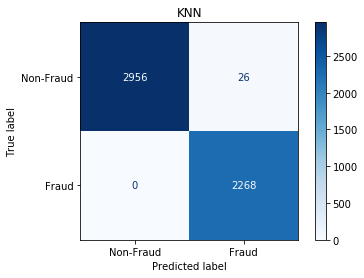

LR
[[2924   58]
 [ 213 2055]]


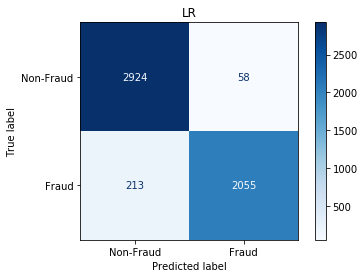

SVM
[[2963   19]
 [ 210 2058]]


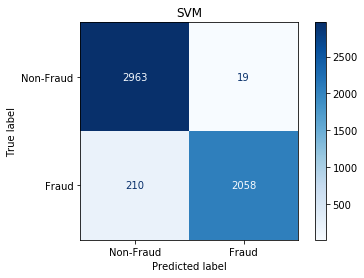

RFT
[[2979    3]
 [ 188 2080]]


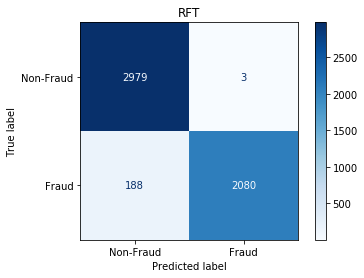

In [44]:
# model names, models and predicted values for each model
models = {'KNN':[knn, knn_ypred], 'LR':[lr, lr_ypred], 'SVM':[svm, svm_ypred], 'RFT':[rft, rft_ypred]}

# list of classes
class_names = ['Non-Fraud','Fraud']

# blank dictionaries for saving evaluation metrics for each model 
accuracy = {}
f1_score_dict = {}
precision = {}
recall = {}

for model, model_output in models.items():
    acc = accuracy_score(y_test, model_output[1]) # accuracy
    pre = precision_score(y_test, model_output[1]) # precision
    rec = recall_score(y_test, model_output[1]) # recall
    f1_sc = f1_score(y_test, model_output[1]) # f1 score
    
    # rounding and saving values to disctionary
    accuracy[model] = round(acc,3)
    precision[model] = round(pre,3)
    recall[model] = round(rec,3)
    f1_score_dict[model] = round(f1_sc,3)

    # plotting confusion matrix for each model
    disp = plot_confusion_matrix(
        model_output[0], X_test, y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues
    )

    disp.ax_.set_title(model)

    print(model)
    print(disp.confusion_matrix)

    plt.show()


In [48]:
print(pd.Series(accuracy).to_frame('Accuracy'))
print('--------------')
print(pd.Series(recall).to_frame('Recall'))
print('--------------')
print(pd.Series(precision).to_frame('Precision'))
print('--------------')
print(pd.Series(f1_score_dict).to_frame('F1 Score'))

     Accuracy
KNN  0.995048
LR   0.948381
SVM  0.956381
RFT  0.963619
--------------
       Recall
KNN  1.000000
LR   0.906085
SVM  0.907407
RFT  0.917108
--------------
     Precision
KNN   0.988666
LR    0.972551
SVM   0.990852
RFT   0.998560
--------------
     F1 Score
KNN  0.994301
LR   0.938142
SVM  0.947296
RFT  0.956102


From the results and confusion matrix above we can define winners for each metrics:

Accuracy: KNN
Precision: RFT
Recall: KNN
F1 Score: KNN

Now, the goal of the model was to detect the fraud cases.
Recall is a vital metrics for that. As KNN is performing best in recall and also in Accuracy and F1 Score, KNN is overall the best model for this particular task.